# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
config_file = 'config/config_commodities_2012_2018.json'

### Import Configurations

In [3]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [4]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [5]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [6]:
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_long_updated')

In [7]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            (config['dataset']['training_initial_date'],
                                                             config['dataset']['training_final_date']),
                                                            (config['dataset']['testing_initial_date'],
                                                             config['dataset']['testing_final_date']),
                                                            remove_nan=True)

Total of 208 tickers
Total of 110 tickers after removing tickers with Nan values


In [8]:
len(df_prices_train)+len(df_prices_test)

1509

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

**Obtain returns**

In [9]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,AMJ,AMLP,BCM,BNO,BOIL,CANE,CGW,CHIE,COPX,...,USLV,USO,USV,VDE,WEAT,XES,XLE,XME,XOP,ZSL
2012-01-04,-0.029769,0.010491,0.006611,0.030028,0.013477,0.077903,0.021840,0.001572,-0.005091,0.007402,...,-0.045905,0.002016,0.011554,0.002994,-0.011572,-0.002499,0.002111,0.002515,0.011711,0.031907
2012-01-05,0.006914,0.004811,0.002985,-0.009040,-0.008992,-0.080455,-0.061241,-0.007845,0.009782,-0.011756,...,0.012893,-0.015087,0.004131,-0.004237,-0.021176,-0.009465,-0.004775,-0.010421,-0.001809,-0.008433
2012-01-06,-0.041845,-0.007812,-0.004762,0.000228,0.007668,0.065744,0.000438,-0.010016,-0.013107,-0.009665,...,-0.061223,0.001276,-0.009681,-0.006092,-0.006903,0.000562,-0.005927,0.000585,-0.010872,0.039688
2012-01-09,0.017469,-0.007874,-0.005981,0.003874,-0.009639,-0.035487,0.006565,0.004260,0.021542,-0.005255,...,0.024803,-0.003570,-0.002933,0.003795,0.013434,0.002247,0.004827,-0.004580,-0.004946,-0.014315
2012-01-10,0.064495,-0.001792,-0.002407,0.007951,0.007555,-0.063718,0.000000,0.010604,0.014088,0.031698,...,0.098558,0.006653,0.033235,0.008627,-0.005025,0.026626,0.008901,0.027509,0.013623,-0.066390


In [10]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  5995.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [11]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[0.02746123 0.0123935  0.00515035 0.00358399 0.00212985 0.00093609
 0.00079511 0.00067723 0.00066944 0.00044616 0.0004296  0.00033127
 0.0003003  0.0002887  0.00023502 0.00021629 0.00021088 0.00020149
 0.00019428 0.00019219]


In [12]:
N_PRIN_COMPONENTS = 12#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)

**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [13]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 13
Pairs to evaluate: 55


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [14]:
print(counts)

8     5
11    4
5     4
3     4
2     4
1     4
12    3
10    3
4     3
0     3
9     2
7     2
6     2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [15]:
X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  df_returns,
                                                                                  config['clustering'])


Number of components:  10
Returns shape:  (1005, 110)
Clusters discovered: 13
Pairs to evaluate: 113
Silhouette score  0.044991528587392096

Number of components:  11
Returns shape:  (1005, 110)
Clusters discovered: 13
Pairs to evaluate: 57
Silhouette score  -0.02497980385884669

Number of components:  12
Returns shape:  (1005, 110)
Clusters discovered: 13
Pairs to evaluate: 55
Silhouette score  -0.02750509432265388

Number of components:  13
Returns shape:  (1005, 110)
Clusters discovered: 13
Pairs to evaluate: 41
Silhouette score  -0.07590407076575492

Number of components:  14
Returns shape:  (1005, 110)
Clusters discovered: 13
Pairs to evaluate: 41
Silhouette score  -0.08025246790490224

Number of components:  15
Returns shape:  (1005, 110)
Clusters discovered: 12
Pairs to evaluate: 27
Silhouette score  -0.14371711208574703

Number of components:  16
Returns shape:  (1005, 110)
Clusters discovered: 10
Pairs to evaluate: 20
Silhouette score  -0.1766100434031975

Number of component

**Fundamental analysis for clusters**

In [16]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [17]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker            Segment
145    AMJ  Equity: U.S. MLPs
200   MLPG  Equity: U.S. MLPs
148   MLPI  Equity: U.S. MLPs

Cluster 1:
    Ticker                    Segment
69     BCM  Commodities: Broad Market
26     DBC  Commodities: Broad Market
134    RJI  Commodities: Broad Market
65     UCI  Commodities: Broad Market

Cluster 2:
    Ticker                        Segment
58     BNO  Commodities: Energy Crude Oil
41     DBO  Commodities: Energy Crude Oil
135    RJN            Commodities: Energy
66     USL  Commodities: Energy Crude Oil

Cluster 3:
    Ticker                        Segment
375    CGW           Equity: Global Water
376    FIW           Equity: Global Water
277    NLR  Equity: Global Nuclear Energy
374    PHO           Equity: Global Water
377    PIO           Equity: Global Water

Cluster 4:
   Ticker                   Segment
0     DBA  Commodities: Agriculture
18    RJA  Commodities: Agriculture

Cluster 5:
   Ticker                              Segment
9

**Visualizing with t-sne**

In [18]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

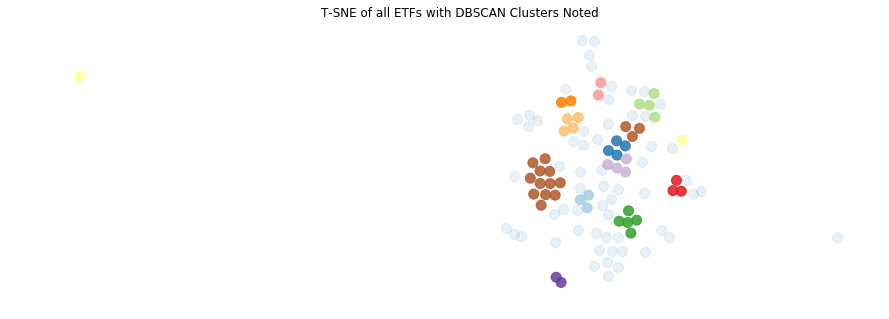

In [19]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

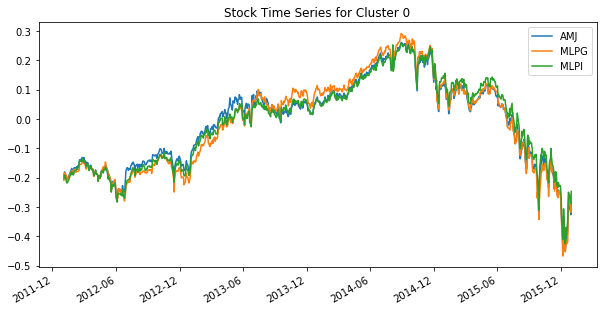

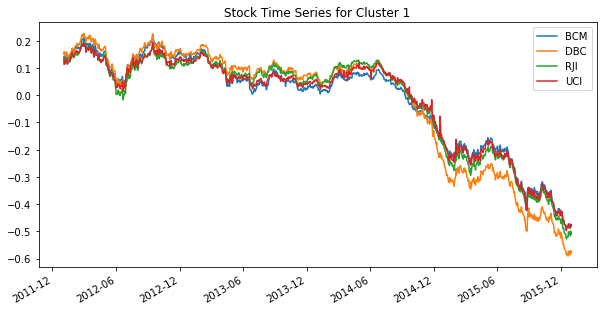

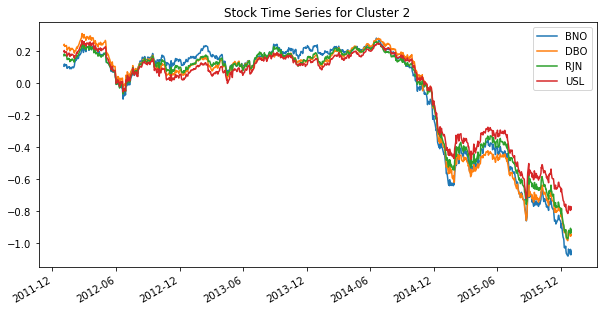

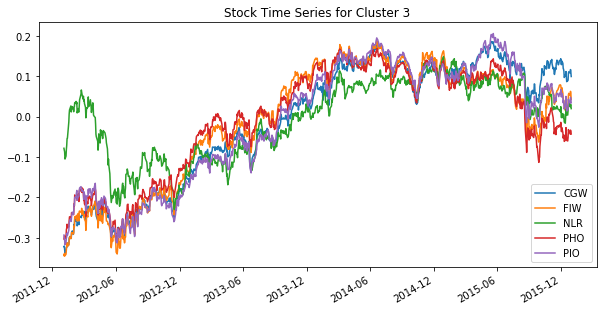

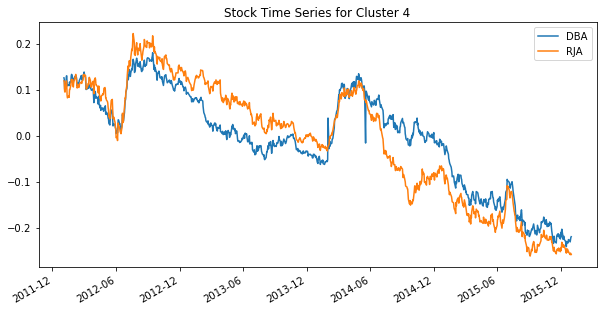

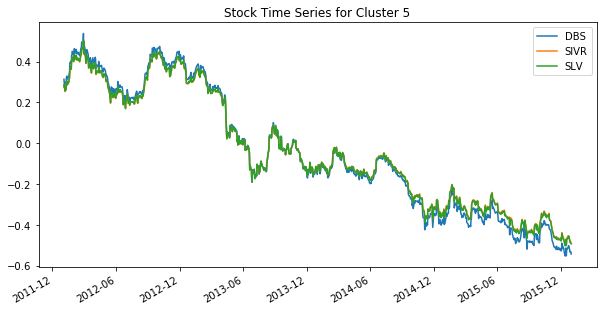

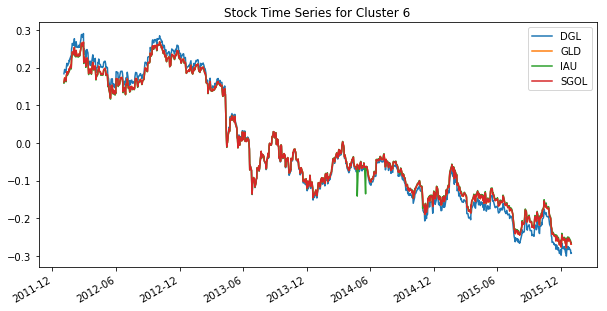

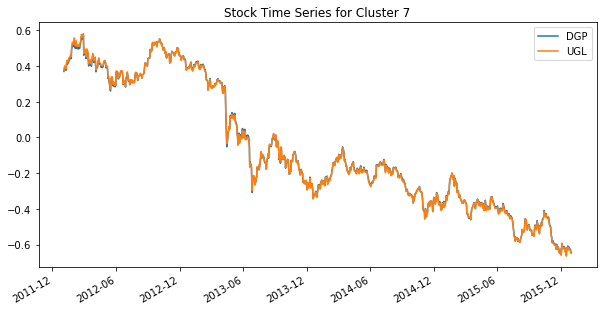

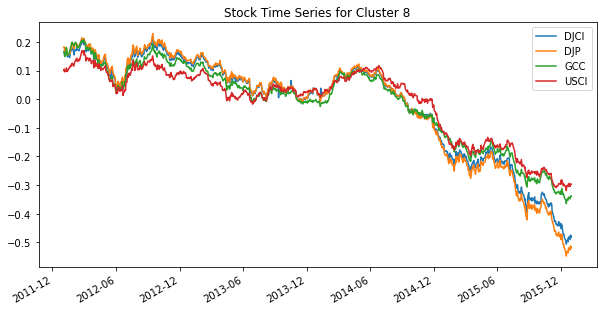

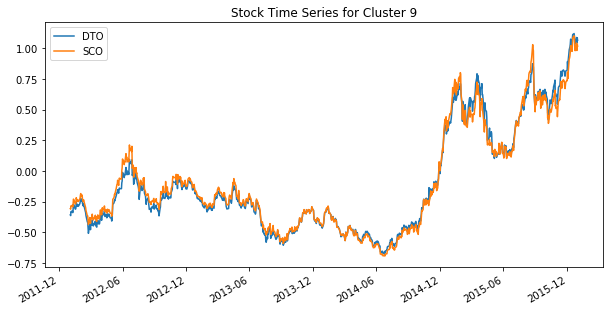

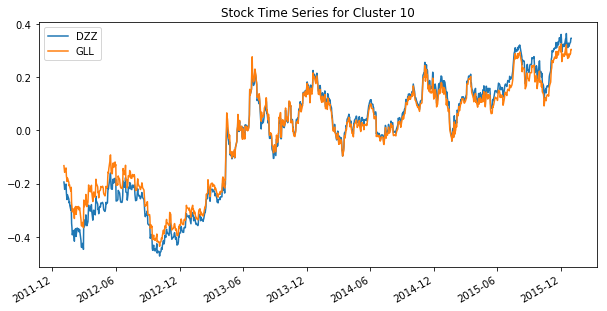

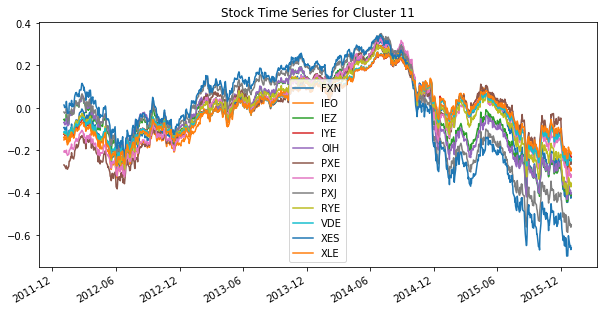

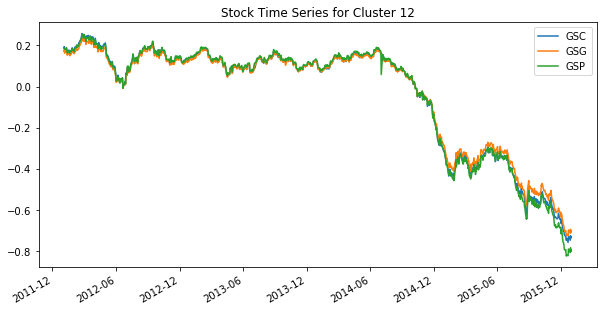

In [20]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [21]:
pairs, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            n_clusters=len(counts),
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 17 pairs
The pairs contain 23 unique tickers


In [22]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

In [23]:
n_years_train = round(len(df_prices_train)/240)

**Applying Bollinger Bands**

In [24]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter,
                                                                                         test_mode=False
                                                                                         )

**Bollinger Bands Performance**

In [25]:
avg_sharpe_bollinger, total_roi_bollinger, anual_roi_bollinger, positive_pct_bollinger = \
    trader.calculate_metrics(sharpe_results_bollinger, cum_returns_bollinger, n_years_train)

Average result:  0.5739777154144357
avg_total_roi:  5.133041121373183
avg_annual_roi:  1.259273416858453
70.58823529411765 % of the pairs had positive returns


**Applying the Kalman filter based strategy**

In [26]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)

In [27]:
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  1.3883919769671862
avg_total_roi:  7.274958290041393
avg_annual_roi:  1.7711281066795648
82.3529411764706 % of the pairs had positive returns


Sharpe Ratio Distribution: 


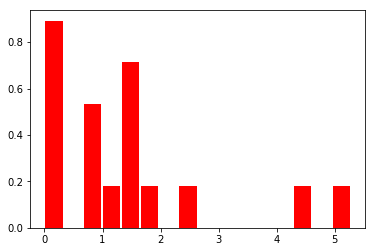

In [28]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [29]:
n_years_test = round(len(df_prices_test)/240)

### Approach 1: Keeping every pair

**Bollinger Bands Out-of-Sample**

In [30]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True
                                                                    )

In [31]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  -0.06032054322524984
avg_total_roi:  0.17930110086556783
avg_annual_roi:  0.08961040031356671
47.05882352941177 % of the pairs had positive returns


**Kalman Out-of-Sample**

In [32]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [33]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
        trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  0.8856513480355266
avg_total_roi:  7.259167952575459
avg_annual_roi:  3.566002120664802
70.58823529411765 % of the pairs had positive returns


### Approach 2: Keeping only pairs that had positive returns in the training period

**Bollinger Strategy**

In [34]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
profitable_pairs_indices = np.argwhere(sharpe_results_bollinger > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [35]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(profitable_pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True)

In [36]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  -0.12489811675218221
avg_total_roi:  -1.0169251799844043
avg_annual_roi:  -0.5097618758425182
33.333333333333336 % of the pairs had positive returns


**Kalman Strategy**

In [37]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
profitable_pairs_indices = np.argwhere(sharpe_results_kalman > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [38]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [39]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.0032029463238614
avg_total_roi:  8.306314018439647
avg_annual_roi:  4.0703195048615415
78.57142857142857 % of the pairs had positive returns


We can conclude that the 2nd approach presents better results. From now on, we assume the 2nd approach was taken.

# Validate the results

The results obtained are suspiciously high. We pretend to look deeper into the numbers.

In [40]:
results, pairs_summary = trader.summarize_results(sharpe_results_kalman_test, cum_returns_kalman_test,
                                                  performance_kalman_test, profitable_pairs)

Average result:  1.0032029463238614
avg_total_roi:  8.306314018439647
avg_annual_roi:  4.0703195048615415
78.57142857142857 % of the pairs had positive returns
[ 3  2  5  1 13 12  6 10  9  7  0  4 11  8]


In [41]:
pairs_summary

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,negative_trades_per_pair_pct
0,DGP,UGL,-3.153197,0.022859,88,18,0.319796,77,18,3.822491,18.947368
1,NLR,PIO,-2.947240,0.040124,78,43,0.397175,145,41,3.127166,22.043011
2,DZZ,GLL,-4.390077,0.000309,35,17,0.277436,197,36,2.707424,15.450644
3,BNO,USL,-2.971615,0.037632,51,53,0.489585,30,9,1.805260,23.076923
4,PXI,XLE,-3.088243,0.027436,64,37,0.401988,106,54,1.556705,33.750000
5,PXI,VDE,-3.172363,0.021641,47,34,0.407237,6,1,1.157440,14.285714
6,FXN,RYE,-2.963271,0.038470,63,16,0.404048,114,53,0.909002,31.736527
7,IYE,PXI,-3.505389,0.007850,67,29,0.385384,56,34,0.430021,37.777778
8,IEO,XLE,-3.671569,0.004531,65,26,0.358570,45,19,0.367823,29.687500
9,IEO,IYE,-3.544552,0.006914,64,28,0.338197,73,29,0.266620,28.431373


**Controlling for range of returns**

In [42]:
print('Maximum return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].max())

Maximum return obtained in a single trade, per pair
2.403420893317443
2.354692061771546
2.3564109485216367
1.9376661384386207
2.1558998090268178
1.4950204979007342
0.6725125054336534
1.4138471509132167
0.7481989003098155
1.646003740133417
3.086797668074759
0.4590415436537709
1.0681480980952562
2.22016843660664


In [43]:
print('Worst return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].min())

Worst return obtained in a single trade, per pair
-1.0903319279076507
-0.8869241633514102
-2.255909559651481
-2.3078227668500206
-2.643232198587775
-3.393545857189051
-1.3919802611188414
-3.4313805301383615
-2.293050677998054
-2.2044439925099857
-2.240251904574375
-1.1818469230653217
-0.9838837827654379
-2.785832126110932


Tanto as returns máximas como as mínimas parecem ter valores dentro da normalidade.

## Training vs Validation

For a far comparison, we should compare the test resuls with the results obtained in the training set, but also using only the profitable pairs:

In [44]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  1.6859045434601543
avg_total_roi:  8.833877923621694
avg_annual_roi:  2.1388646439761683
100.0 % of the pairs had positive returns


In [45]:
print('The sharpe ratio obtained in the training set with the pairs used on the test set is ', avg_sharpe_kalman)
print('The sharpe ratio obtained in the test set is ', avg_sharpe_kalman_test)

The sharpe ratio obtained in the training set with the pairs used on the test set is  1.6859045434601543
The sharpe ratio obtained in the test set is  1.0032029463238614


As expected, the sharpe ratio is indeed higher in the training set.

In [46]:
len(pairs)

17

In [47]:
len(profitable_pairs)

14

## Analyzing Pairs' Overlap

There could be two possible interpretations for pairs' overlap.
1. We might be interested in checking which of the cointegrated pairs found in the training dataset are also cointegrated in the test set; Furthermore we want to explore how the two types of pairs perform.
2. We might be interested in finding if the pairs that would have been found in the test set by performing PCA + clustering would be cointegrated in the training set.

Starting with **1)**, let's see how many of the identified pairs actually turned out to be cointegrated during this period.

In [48]:
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the training set are also cointegrated in the test set'.format(\
    len(pairs_overlapped), len(pairs)))

6 of the 17 pairs identified in the training set are also cointegrated in the test set


In [49]:
profitable_pairs_overlapped, profitable_pairs_overlapped_index = series_analyser.pairs_overlap(profitable_pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs with positive returns identified in the training set are also cointegrated in the test set'.format(\
    len(profitable_pairs_overlapped), len(profitable_pairs)))

6 of the 14 pairs with positive returns identified in the training set are also cointegrated in the test set


### Is cointegration really important?

To answer this question we will see how many of the still cointegrated pairs had positive and negative returns. We will then do the same for those pairs that were not cointegrated. 

If both are as likely to have positive and negative returns, then it means cointegration is not as important of a condition. On the other hand, if we verify that all pairs that are still cointegrated turned out to be profitable and those that are not anymore led to consistent negative returns, we can infer that cointegration is a very important predictor of future returns.

We also compare the average performance of the two groups two see the relevance of being cointegrated with respect to the sharpe ratio obtained.

*Still cointegrated*

In [50]:
# distribution for pairs which were cointegrated in train and test
sharpe_results_pairs_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])
cum_returns_pairs_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])

if len(sharpe_results_pairs_overlapped)>0:
    _,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_overlapped, cum_returns_pairs_overlapped,
                                   n_years_test)
else:
    print('0% of the pairs cointegrated in the train are also cointegrated in the test set')

Average result:  1.0339287251232336
avg_total_roi:  10.278966244639626
avg_annual_roi:  5.013792543950912
66.66666666666667 % of the pairs had positive returns


*Not cointegrated anymore*

In [51]:
# distribution for pairs which were cointegrated in train but not in test
profitable_pairs_not_overlapped_index = [i for i in np.arange(0,len(profitable_pairs))\
                                         if i not in profitable_pairs_overlapped_index]

sharpe_results_pairs_not_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

cum_returns_pairs_not_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_not_overlapped, cum_returns_pairs_not_overlapped,
                                   n_years_test)

Average result:  0.9801586122243324
avg_total_roi:  6.826824848789661
avg_annual_roi:  3.3570630623711573
87.5 % of the pairs had positive returns


Answering to the first question we were concerned with, we verify that a cointegrated pair is indeed more likely to have a positive return. Furthermore, we can conclude from the results that being cointegrated implied that those pairs generated higher returns. 

**TO REVIEW:Conclusion**: The fact that a pair is not cointegrated anymore does not impact the results obained. In fact, we just concluded that betting solely on the cointegrated pairs would yield a worse result. Therefore, we should not spend much effort in detecting pairs that are no cointegrated anymore.

Following with point number **2)**, we proceed to analyze the performance of the pairs that woud have been identified in the testing period.

In [52]:
initial_test_date = config['dataset']['testing_initial_date']
final_teste_date = config['dataset']['testing_final_date']

# Get returns for test period
df_returns_test = data_processor.get_return_series(df_prices_test)

# APPLY PCA and CLUSTERING
range_n_components = config['PCA']['N_COMPONENTS']
X_test, clustered_series_all_test, clustered_series_test, counts_test, clf_test = \
            series_analyser.clustering_for_optimal_PCA(range_n_components[0], range_n_components[1],
                                                       df_returns_test, config['clustering'])
# Find pairs
pairs_test, unique_tickers_test = series_analyser.get_candidate_pairs(\
                                            clustered_series=clustered_series_test,
                                            pricing_df_train=df_prices_test,
                                            pricing_df_test=df_prices_train,
                                            n_clusters=len(counts_test),
                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                            )

# Finally, see overlap
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs_test,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the test set are also cointegrated in the training set'.format(\
    len(pairs_overlapped), len(pairs_test)))


Number of components:  10
Returns shape:  (502, 110)
Clusters discovered: 10
Pairs to evaluate: 131
Silhouette score  -0.060471083528586184

Number of components:  11
Returns shape:  (502, 110)
Clusters discovered: 10
Pairs to evaluate: 68
Silhouette score  -0.13056496627944275

Number of components:  12
Returns shape:  (502, 110)
Clusters discovered: 10
Pairs to evaluate: 33
Silhouette score  -0.21471191163842762

Number of components:  13
Returns shape:  (502, 110)
Clusters discovered: 9
Pairs to evaluate: 23
Silhouette score  -0.24915928943596874

Number of components:  14
Returns shape:  (502, 110)
Clusters discovered: 8
Pairs to evaluate: 22
Silhouette score  -0.2314142309816213

The best silhouette coefficient was: -0.060471083528586184 for 10 principal components
Found 15 pairs
The pairs contain 23 unique tickers
2 of the 15 pairs identified in the test set are also cointegrated in the training set


Let's see if the pairs identified in the test period lead indeed to improved results:

In [53]:
sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs, performance_kalman_test_newpairs =\
    trader.apply_kalman_strategy(pairs_test, entry_multiplier,exit_multiplier,trading_filter, test_mode=False)

_,_,_,_ = trader.calculate_metrics(sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs,
                                   n_years_test)

Average result:  1.4039587512883185
avg_total_roi:  6.8050242886989505
avg_annual_roi:  3.3465162880195853
73.33333333333333 % of the pairs had positive returns


The sharpe ratio is higher in this scenatio. Note hoewever, that the annual ROI is not so high as the pairs identified previously. This might be linked with the fact that these pairs did not prove to be cointegrated for a period as long as the other and therefore the pairs might be less stable.

### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

In [55]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

NameError: name 'failed_pairs' is not defined

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [380]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

-0.04480324434678721


However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [376]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.021426798923804273


We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [60]:
sharpe_results_kalman_test = np.asarray(sharpe_results_kalman_test)
negative_pairs_indices = np.argwhere(sharpe_results_kalman_test < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(pairs)))

0 out of 13 pairs turned out to be non-profitable


Let's get some more information on the non-profitable pairs:

In [109]:
negative_pairs = [pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

[('IEO', 'IYE'),
 ('BAL', 'GCC'),
 ('BAL', 'USCI'),
 ('DJP', 'GCC'),
 ('BNO', 'UGA'),
 ('DBE', 'UGA'),
 ('UGA', 'USL'),
 ('UGA', 'USO'),
 ('CORN', 'JJG')]

To what clusters do these pairs belong?

In [110]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

Pair ('IEO', 'IYE') belongs to cluster 0
Pair ('BAL', 'GCC') belongs to cluster 1
Pair ('BAL', 'USCI') belongs to cluster 1
Pair ('DJP', 'GCC') belongs to cluster 1
Pair ('BNO', 'UGA') belongs to cluster 3
Pair ('DBE', 'UGA') belongs to cluster 3
Pair ('UGA', 'USL') belongs to cluster 3
Pair ('UGA', 'USO') belongs to cluster 3
Pair ('CORN', 'JJG') belongs to cluster 5


How do the statistics rank?

In [111]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([pairs[index][0],
                 pairs[index][1],
                 pairs[index][2]['t_statistic'],
                 pairs[index][2]['p_value'],
                 pairs[index][2]['zero_cross'],
                 pairs[index][2]['half_life'],
                 pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive trades,negative_trades,sharpe_result
0,CORN,GRU,-3.404058,0.010821,104,28,0.419100,19,14,7.874875
1,RJN,USL,-2.988861,0.035948,114,35,0.439754,16,9,7.050578
2,RJA,SOYB,-4.474279,0.000219,98,21,0.360609,20,22,5.984475
3,RJN,USO,-3.351293,0.012736,95,37,0.439245,16,6,5.897631
4,JJC,JJM,-3.097372,0.026748,80,22,0.329256,24,15,5.699725
5,GRU,WEAT,-3.909307,0.001967,106,37,0.466337,16,7,5.586175
6,DBO,RJN,-3.365444,0.012195,115,30,0.427794,17,10,5.496269
7,DGP,UGL,-3.205752,0.019654,73,14,0.335867,39,28,3.986749
8,JJA,WEAT,-3.117105,0.025313,74,54,0.444761,7,7,3.866423
9,DJCI,GCC,-3.167705,0.021932,81,21,0.361562,27,14,3.568772


In [112]:
df.half_life.mean()

42.28

In [113]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Half-life vs Sharpe Ratio correlation:  -0.4545065959240087
Zero crossings vs Sharpe Ratio correlation:  0.41834257704466227
p-value vs Sharpe Ratio correlation:  0.02552538602418196
t-statistic vs Sharpe Ratio correlation:  0.09585827383877676
Hurst exponent vs Sharpe Ratio correlation  -0.07104130200064852


Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns

# What if we haven't done any clustering?

**All against all** - *comparing against the simplest strategy*

In [201]:
no_cluster_series = pd.Series(0,index = etfs_pricing.columns)
total_pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=1,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(total_pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 273 pairs
The pairs contain 41 unique tickers
Found 273 pairs


Bollinger Bands:

In [203]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

sharpe_results_boll_aaa, cum_returns_boll_aaa, performance_boll_aaa = trader.apply_bollinger_strategy(total_pairs_all_a_all,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



ALTY,DBV
APR -0.019690076598853357
Sharpe -0.37666046873915465


ALTY,DIVA
APR -0.025647640984403308
Sharpe -0.6268695474526955


ALTY,FLAT
APR 0.08703113849382382
Sharpe 2.030807685607455


ALTY,FUT
APR -0.00956969317643086
Sharpe -0.24988167683679713


ALTY,MRGR
APR -0.03981804664306354
Sharpe -1.0451248382719696


ALTY,SIZ
APR 0.04559781673716912
Sharpe 0.9427153906928085


ALTY,STPP
APR -0.04367292586973193
Sharpe -0.5331008817168248


ALTY,TVIX
APR 0.15845242756404643
Sharpe 1.115245313399877


ALTY,UVXY
APR 0.1815796270931438
Sharpe 1.2097981203596972


BTAL,DIVY
APR 0.017862582442937258
Sharpe 0.5720161966008018


BTAL,FUT
APR 0.029607195121189145
Sharpe 0.7547881999532214


BTAL,JPHF
APR 0.013638947462838669
Sharpe 0.448227225572819


CHEP,DIVA
APR 0.04564442310806638
Sharpe 0.8075868719931734


CHEP,DIVY
APR 0.023734801604629485
Sharpe 0.8278376545038248


CHEP,FTLS
APR -0.05475313592423159
Sharpe -0.5285461968372713


CHEP,FUT
APR 0.07843386895838855
Sharpe 0.95411644317309

APR 0.00018772807011280257
Sharpe 0.02526143334356859


DIVA,RINF
APR -0.045554115023159425
Sharpe -0.9852954618389087


DIVA,RLY
APR -0.01896471359405061
Sharpe -0.4051598950197042


DIVA,SIZ
APR 0.04684659395991919
Sharpe 0.9843676193258001


DIVA,STPP
APR 0.08510554058169872
Sharpe 1.4779415908917648


DIVA,TVIX
APR 0.04146312860638357
Sharpe 0.5933366926315745


DIVA,UVXY
APR 0.05205618217328323
Sharpe 0.734026628385942


DIVA,VEGA
APR -0.05642056614856672
Sharpe -1.564124480081488


DIVA,VIIX
APR 0.11407931714193853
Sharpe 1.9963207888977776


DIVA,VIXM
APR 0.10549016666101863
Sharpe 1.729224592760924


DIVA,VIXY
APR 0.10904664755240456
Sharpe 1.8996972497442384


DIVA,WTMF
APR 0.044035992860706585
Sharpe 1.149769501876805


DIVA,XVZ
APR 0.05254693458806314
Sharpe 1.122031104003971


DIVA,ZIV
APR -0.08165630755618969
Sharpe -1.4003938728604428


DIVY,DYB
APR -0.024569195016881595
Sharpe -0.9748186210390113


DIVY,FMF
APR -0.03682071366157491
Sharpe -1.2561063428888681


DIVY,MNA
A

APR -0.013264208326657423
Sharpe -0.2819939172430328


FUT,GAA
APR 0.03096986960422865
Sharpe 0.9009555733700528


FUT,HTUS
APR 0.02303278694396793
Sharpe 0.7388046003734902


FUT,JPHF
APR 0.04081425011189066
Sharpe 1.572016704331324


FUT,MCRO
APR 0.00807815069318174
Sharpe 0.297958642354598


FUT,MNA
APR -0.0033786845322384407
Sharpe -0.11191925393761408


FUT,MOM
APR 0.04525950443613991
Sharpe 1.2925014335620562


FUT,QAI
APR 0.01793785247566615
Sharpe 0.7177366576557209


FUT,QED
APR -0.05365952144185904
Sharpe -2.052228008273042


FUT,QLS
APR -0.015262384741230317
Sharpe -0.4599074662859895


FUT,QMN
APR 0.007898676507078983
Sharpe 0.33744439145744165


FUT,SIZ
APR -0.011701496822161261
Sharpe -0.27763578578786585


FUT,SVXY
APR -0.008735844000838489
Sharpe -0.18056608916994585


FUT,TVIX
APR -0.03348761812613865
Sharpe -0.701280205107946


FUT,UVXY
APR -0.03202798418065267
Sharpe -0.6713121003841697


FUT,VEGA
APR 0.01130011645109752
Sharpe 0.36898880399202194


FUT,VIIX
APR -0.0

APR -0.028810665304430882
Sharpe -1.2156909622290077


MNA,QMN
APR -0.033148208661512135
Sharpe -1.6304147225551633


MNA,SIZ
APR 0.011458415759262097
Sharpe 0.40091680518302564


MNA,STPP
APR -0.01104767493098513
Sharpe -0.35664442759613796


MNA,TVIX
APR -0.23912276535886245
Sharpe -1.199030258589216


MNA,UVXY
APR -0.28672377462857124
Sharpe -1.5504418831513092


MNA,VEGA
APR -0.024743814592359192
Sharpe -1.0502076686306336


MNA,VIIX
APR 0.03360939211634384
Sharpe 0.8987617039516559


MNA,VIXY
APR 0.031560052556113716
Sharpe 0.8232540108156807


MNA,XVZ
APR 0.022780270316132167
Sharpe 0.7999483838926853


MNA,ZIV
APR -0.05309244144173597
Sharpe -1.7050645354947593


MOM,QMN
APR -0.06338503702109777
Sharpe -2.1737886560424227


MOM,TVIX
APR -0.17228317345691957
Sharpe -0.5554809421259133


MOM,UVXY
APR -0.1987058073885467
Sharpe -0.7160483875003189


MOM,VEGA
APR -0.015207803828720112
Sharpe -0.3069874371281602


MRGR,QAI
APR -0.0218363270668418
Sharpe -1.098622853595885


MRGR,QED


APR 0.12781076619854614
Sharpe 0.967694694316533


TVIX,VIXM
APR -0.030107075046490128
Sharpe -0.16383633581407728


TVIX,XVZ
APR 0.11805659011942726
Sharpe 0.5190886067989029


UVXY,VEGA
APR 0.11959576123471938
Sharpe 0.9102157036559749


UVXY,VIXM
APR -0.0444710409582616
Sharpe -0.27552171159037575


UVXY,XVZ
APR 0.44063357459775543
Sharpe 1.0367498642915272


VEGA,VIXM
APR 0.09727167638303924
Sharpe 1.2950686313414943


VIIX,ZIV
APR -0.08401676285230242
Sharpe -0.8172407043595594


VIXY,ZIV
APR -0.13274753935170802
Sharpe -1.3632337600605549


Sharpe Ratio Results (considering entire universe): 
Average result:  -0.2182626320695486


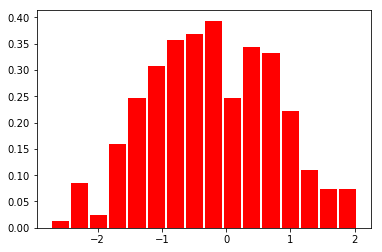

In [205]:
print('Sharpe Ratio Results (considering entire universe): ')
n, bins, patches = plt.hist(sharpe_results_boll_aaa, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_boll_aaa))

Kalman filter:

In [690]:
entry_multiplier=2
exit_multiplier=0.5

sharpe_results_kalman_all_a_all, cum_returns_kalman_all_all = apply_kalman_strategy(total_pairs_all_a_all,
                                                                                    entry_multiplier,
                                                                                    exit_multiplier)

NameError: name 'apply_kalman_strategy' is not defined

Sharpe Ratio Results (considering the entire universe): 
Average result:  0.2917998463678402


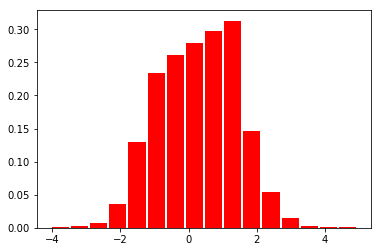

In [84]:
print('Sharpe Ratio Results (considering the entire universe): ')
n, bins, patches = plt.hist(sharpe_results_kalman_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman_all_a_all))